In [2]:
from torch.quantization import MovingAverageMinMaxObserver
from torch.ao.quantization.observer import MinMaxObserver
from torch.quantization import QuantStub, DeQuantStub
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10
from art.preprocessing.standardisation_mean_std import StandardisationMeanStdPyTorch
from art.attacks.evasion.hop_skip_jump import HopSkipJump
import time
import pickle
import os
from math import log10, sqrt
import cv2
from torch.utils.data import DataLoader
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def print_size_of_model(model):
    """ Prints the real size of the model """
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

    
def accuracy(output, target):
    """ Computes the top 1 accuracy """
    with torch.no_grad():
        batch_size = target.size(0)

        _, pred = output.topk(1, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        correct_one = correct[:1].view(-1).float().sum(0, keepdim=True)
        return correct_one.mul_(100.0 / batch_size).item()


def test(model: nn.Module, dataloader: DataLoader, cuda=False) -> float:
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            if cuda:
              inputs = inputs.cuda()
              labels = labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


100%|██████████| 170498071/170498071 [00:17<00:00, 9656753.90it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Files already downloaded and verified


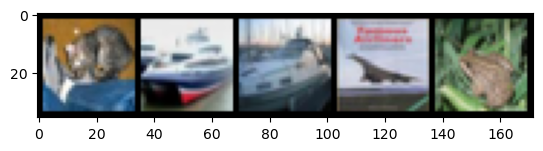

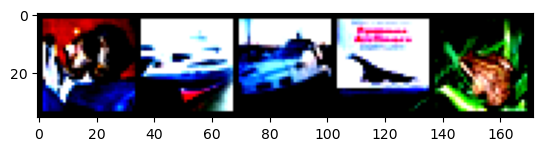

In [3]:
image_set = pickle.load(open("fashionmnist_images.pkl",'rb'))
label_set = pickle.load(open("fashionmnist_label.pkl",'rb'))

transform = transforms.Compose([transforms.ToTensor(),])
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False, num_workers=16, pin_memory=True)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
from functools import partial
from typing import Dict, Type, Any, Callable, Union, List, Optional
from torch.ao.nn.quantized.modules.functional_modules import FloatFunctional

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.ff = torch.nn.quantized.FloatFunctional()
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        #out = self.ff.add(out, identity)
        out = self.relu(out)

        return out


class CifarResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        super(CifarResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = conv3x3(1, 16)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

model = CifarResNet(BasicBlock,[3]*3)

In [4]:
device_avail = "cuda:0"


model.load_state_dict(torch.load("ResNet20_FashionMnist_92.24acc.pkl"))
model.float()
model.to(device_avail)
model.eval()



# Step 2a: Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, dampening=0,weight_decay=0.0005, nesterov=True)

score = test(model, testloader, cuda=True)
print('Accuracy of the network on the test images: {}% - FP32'.format(score))
print("Size of model before quantization")
print_size_of_model(model)

# Step 3: Create the ART classifier
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0.0, 1.0),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
    device_type = device_avail
)
print("HopSkipJump Attack Initialization")

attack = HopSkipJump(classifier,64,targeted = False,verbose = True)

for i in range(0,100):
    x_train_hop_res20_fashion = attack.generate(image_set[0+300*i:300*(i+1)],label_set[0+300*i:300*(i+1)])
    with open("x_train_hop_res20_fashion_{}_to_{}.pkl".format(300*i,300*(i+1)),'wb') as f:
        pickle.dump(x_train_hop_res20_fashion,f)
    with open("resnet20_fashion_progress.txt",'wb') as f:
        f.write("Done with {}\n".format(300*(i+1)))

/opt/conda/lib/python3.10/site-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet56-187c023a.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet56-187c023a.pt
100%|██████████| 3.39M/3.39M [00:00<00:00, 87.2MB/s

Accuracy of the network on the test images: 94.37% - FP32
Size of model before quantization
Size (MB): 3.533123
HopSkipJump Attack Initialization


HopSkipJump:   0%|          | 0/3000 [00:00<?, ?it/s]